## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

C:\Users\Joshua Amresh\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the data

In [2]:
data = pd.read_csv("./Output_CSVs/Prepped Data/iteration1_prepped_data.csv")

## Train Test Split

In [3]:
X = data.drop(['isFraud'], axis = 1)
y = data['isFraud']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    random_state=91)

## SMOTE Sampling

In [6]:
import imblearn

In [7]:
y_train.value_counts()

0    427408
1     15497
Name: isFraud, dtype: int64

In [8]:
y_test.value_counts()

0    142469
1      5166
Name: isFraud, dtype: int64

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

MemoryError: Unable to allocate 1.89 GiB for an array with shape (411911, 615) and data type float64

## UpSampling

In [11]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [13]:
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_train,y_train=smk.fit_resample(X_train,y_train)

MemoryError: Unable to allocate 1.00 GiB for an array with shape (8660, 15497) and data type float64

## Natural Distribution

#### RandomForest

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [10]:
y_train_pred = classifier.predict(X_train)

In [11]:
print("Training Metrics")
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Training Metrics
0.9966990663912125
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    427408
           1       1.00      0.91      0.95     15497

    accuracy                           1.00    442905
   macro avg       1.00      0.95      0.97    442905
weighted avg       1.00      1.00      1.00    442905



In [12]:
y_test_pred = classifier.predict(X_test)

In [13]:
print("Test Metrics")
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Metrics
0.9783046025671419
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.92      0.42      0.57      5166

    accuracy                           0.98    147635
   macro avg       0.95      0.71      0.78    147635
weighted avg       0.98      0.98      0.97    147635



In [7]:
from sklearn.metrics import confusion_matrix

In [15]:
confusion_matrix(y_test,y_test_pred)

array([[142286,    183],
       [  3020,   2146]], dtype=int64)

#### XGBoost (Weighted)

The scale_pos_weight penalizes the majority class, of sorts. That's why able to catch most of the frauds, but consequently predicted many good customers as fraud too as the penalty tries to catch as many frauds as possible. This method will work in other imbalanced usecases, like medical, this method can be used. But for better experience not going with this one in this fraud case

In [16]:
from xgboost import XGBClassifier

In [17]:
from collections import Counter

In [19]:
# count examples in each class
counter = Counter(y_train)
counter

Counter({0: 427408, 1: 15497})

In [20]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 27.580


In [21]:
model = XGBClassifier(scale_pos_weight=27)

In [22]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_train_pred = model.predict(X_train)
print("Training Metrics")
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Training Metrics
0.9298472584414265
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    427408
           1       0.32      0.89      0.47     15497

    accuracy                           0.93    442905
   macro avg       0.66      0.91      0.72    442905
weighted avg       0.97      0.93      0.95    442905



In [24]:
y_test_pred = model.predict(X_test)
print("Test Metrics")
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Metrics
0.9235750330206252
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    142469
           1       0.29      0.82      0.43      5166

    accuracy                           0.92    147635
   macro avg       0.64      0.87      0.69    147635
weighted avg       0.97      0.92      0.94    147635



In [25]:
confusion_matrix(y_test,y_test_pred)

array([[132117,  10352],
       [   931,   4235]], dtype=int64)

Business has to take a call on which of the above model to use. If the business wants to prevent as many frauds as possible, but doesn't pay much attention to the experience of customers who are not fraud but predicted as fraud, then use XGBoost. But if the business is concerned that the experience of customers is priority and does not want to label their non fraud customers as frauds, then use RandomForest. In my personal opinion, I'm going with RandomForest, coz this is customer centred business and the customer is always right.

## Hyperparameter tuning for RandomForest

In [38]:
classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42, min_samples_split = 2,
                                   min_samples_leaf = 20)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=20,
                       n_estimators=50, random_state=42)

In [39]:
y_train_pred = classifier.predict(X_train)
print("Training Metrics")
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

y_test_pred = classifier.predict(X_test)
print("Test Metrics")
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

confusion_matrix(y_test,y_test_pred)

Training Metrics
0.9750804348562333
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    427408
           1       0.93      0.31      0.47     15497

    accuracy                           0.98    442905
   macro avg       0.95      0.66      0.73    442905
weighted avg       0.97      0.98      0.97    442905

Test Metrics
0.9742202052358858
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142469
           1       0.91      0.29      0.44      5166

    accuracy                           0.97    147635
   macro avg       0.94      0.64      0.71    147635
weighted avg       0.97      0.97      0.97    147635



array([[142329,    140],
       [  3666,   1500]], dtype=int64)

In [30]:
classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42, min_samples_split = 2)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=42)

In [31]:
y_train_pred = classifier.predict(X_train)
print("Training Metrics")
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

y_test_pred = classifier.predict(X_test)
print("Test Metrics")
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

confusion_matrix(y_test,y_test_pred)

Training Metrics
0.9997855070500445
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    427408
           1       1.00      0.99      1.00     15497

    accuracy                           1.00    442905
   macro avg       1.00      1.00      1.00    442905
weighted avg       1.00      1.00      1.00    442905

Test Metrics
0.9793273952653504
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.94      0.44      0.60      5166

    accuracy                           0.98    147635
   macro avg       0.96      0.72      0.79    147635
weighted avg       0.98      0.98      0.98    147635



array([[142326,    143],
       [  2909,   2257]], dtype=int64)

In [9]:
from sklearn.model_selection import GridSearchCV

In [ ]:
n_estimators = [20, 50, 100]
max_depth = [5, 8, 15]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(classifier, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV stalled the laptop bigtime. So used the above grid and went manually for the hyper parameter tuning. Like first started with n_estimators and found the best optimal value for that, then fixed it and then went tuning the next subsequent parameters. This is one way, and not the correct way I would say. Coz if I take a different set or path of parameter combinations I can end up with possibly a better result. But for now, this is the approach I have taken and have obtained a best set of parameters as the following section.

## Best Model and Lift Curve

In [40]:
classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42, min_samples_split = 2)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
print("Training Metrics")
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

y_test_pred = classifier.predict(X_test)
print("Test Metrics")
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

confusion_matrix(y_test,y_test_pred)

Training Metrics
0.9997855070500445
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    427408
           1       1.00      0.99      1.00     15497

    accuracy                           1.00    442905
   macro avg       1.00      1.00      1.00    442905
weighted avg       1.00      1.00      1.00    442905

Test Metrics
0.9793273952653504
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.94      0.44      0.60      5166

    accuracy                           0.98    147635
   macro avg       0.96      0.72      0.79    147635
weighted avg       0.98      0.98      0.98    147635



array([[142326,    143],
       [  2909,   2257]], dtype=int64)

In [41]:
def plot_Lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

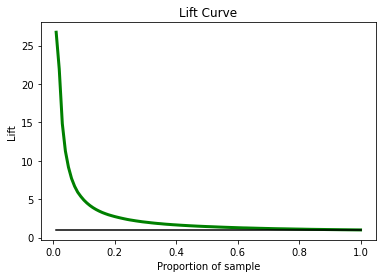

In [42]:
plot_Lift_curve(y_test, y_test_pred)

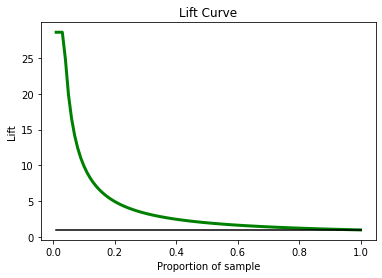

In [43]:
plot_Lift_curve(y_train, y_train_pred)